In [190]:
#The goal of this project is to analyze the google sample data over the year 2016-2017
#I plan on querying the data from google big query and converting it to a dataframe,
#handle any missing data and then using data visualization to graph the
#Revenue, transactions, visits, conversion rate and average order value over time grouped 
#by channel grouping. Then I intend to find insights in the data.
from google.cloud import bigquery
import pandas as pd

In [191]:
client=bigquery.Client()

In [192]:
#I did not know that I could query all the tables using 
#FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*'
#So the solution I found was to union all the tables together by using 
#a loop through all the days in the year. I used a dictionary with 
#with the month as the keys and the amount of days as the values
months = {'08': 31, '09': 30, '10': 31, '11': 30, '12': 31, '01': 31, '02': 28, '03': 31, '04': 30, '05': 31, '06': 30, '07': 31}

In [193]:
#created a query from August 2016 to August 2017 to use for google big query 
#Used union all to combine different month tables with the same schema.
#I found out there is an easier way to do this but it was a fun excercise


date_query='WITH years AS( '
table = 'SELECT date, totals.visits as visits, totals.transactions as transactions, totals.transactionRevenue as revenue, geoNetwork.country as country, channelGrouping as channel FROM `bigquery-public-data.google_analytics_sample.ga_sessions_'
#date = '20160801'
year = '2016'
start = '01'

for month in months:
    if month == '01':
        year = str(int(year) + 1)
    for day in range(months[month]):
        date_query = date_query + table + str(int( year + month + start) + day) +'`' + ' UNION ALL '

date_query = date_query + table + '20170801' +'` ), '


query = ''' incomplete AS( SELECT
PARSE_DATE('%Y%m%d', date) as date,
SUM(visits) as visits,
SUM(transactions) as transactions, 
CASE WHEN SUM(visits)>0
  THEN SUM(transactions)/SUM(visits)
  ELSE 0
  END as conversion_rate,
SUM(revenue) as Revenue,
CASE WHEN SUM(transactions) >0
  THEN SUM(revenue)/SUM(transactions) 
  ELSE 0
  END as ave_order_value,
channel as Channel

FROM years 

GROUP BY date, channel
Order BY transactions desc)

SELECT
date,
EXTRACT(MONTH from date) month_of_year,
EXTRACT(WEEK from date) week_of_year,
visits,
conversion_rate,
transactions,
Revenue,
ave_order_value,
channel,

FROM incomplete
Order BY date
'''



            
        

In [194]:
#converted the query into a dataframe
date_query= date_query + query
query_job = client.query(date_query)
df = query_job.to_dataframe()
df.shape

#making sure that the dataframe looks right 
df.tail()

,date,month_of_year,week_of_year,visits,conversion_rate,transactions,Revenue,ave_order_value,channel
2589,2017-08-01,8,31,52,NaN,NaN,NaN,0.000000e+00,Affiliates
2590,2017-08-01,8,31,1346,0.004458,6.0,6.925400e+08,1.154233e+08,Organic Search
2591,2017-08-01,8,31,70,0.014286,1.0,8.248000e+07,8.248000e+07,Paid Search
2592,2017-08-01,8,31,436,0.066514,29.0,4.970720e+09,1.714041e+08,Referral
2593,2017-08-01,8,31,213,NaN,NaN,NaN,0.000000e+00,Social


In [196]:
#looking at the shape of the dataframe
df.shape

(2594, 9)

In [197]:
#see if there is any missing data
nan_count = df.isnull().sum()
nan_count

date                  0
month_of_year         0
week_of_year          0
visits                0
conversion_rate    1084
transactions       1084
Revenue            1084
ave_order_value       0
channel               0
dtype: int64

In [198]:
#Created a list out of columns that have nan values
nan_cols = ['transactions', 'Revenue']
df[nan_cols].head()

,transactions,Revenue
0,18.0,3.470690e+09
1,8.0,2.246150e+09
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [199]:
#check whether there are any 0 values for transactions or Revenue.
#I did not check conversion rate since it depends on transactions
df[nan_cols].isin([0]).sum()

transactions    0
Revenue         0
dtype: int64

In [200]:
#percent of the missing nan values in the dataframe
per_of_nan_val = 1084/2594
per_of_nan_val

#since there are no rows with 0 transactions, even though there was not any visiting data missing,
#I will make the asumption that the missing data is from people who visited but did not buy anything 
#since the missing data is only 41 percent of the values in the nan_cols

0.41788743253662297

In [201]:
#I decided to fill the missing values with 0 
#because 41 percent of the data was missing and there were not any 0 valuse for people 
#who visited but did not buy anything
cols = ['transactions', 'Revenue', 'conversion_rate']
df_new = df
df_new[cols] = df_new[cols].fillna(0)
df_new.head()

,date,month_of_year,week_of_year,visits,conversion_rate,transactions,Revenue,ave_order_value,channel
0,2016-08-01,8,31,301,0.059801,18.0,3.470690e+09,1.928161e+08,Referral
1,2016-08-01,8,31,607,0.013180,8.0,2.246150e+09,2.807688e+08,Direct
2,2016-08-01,8,31,8,0.000000,0.0,0.000000e+00,0.000000e+00,Affiliates
3,2016-08-01,8,31,25,0.000000,0.0,0.000000e+00,0.000000e+00,Paid Search
4,2016-08-01,8,31,9,0.000000,0.0,0.000000e+00,0.000000e+00,Display


In [202]:
#making sure the shape is the same
df.shape

(2594, 9)

In [203]:
#Finding sum of the variables per channel for the year in order to create a table
#I will use the transactions and visits to calculate conversion rate
#Then I will use Revenue and transactions to calculate total average order value
sums = df_new.groupby(['channel'])[['Revenue', 'transactions', 'visits']].sum().reset_index()
sums = sums.sort_values(by=['Revenue'] ,ascending = False)
sums

,channel,Revenue,transactions,visits
6,Referral,6.514299e+11,5543.0,104838
2,Direct,4.348406e+11,2219.0,143026
4,Organic Search,3.263805e+11,3581.0,381561
3,Display,7.833746e+10,152.0,6262
5,Paid Search,4.355890e+10,479.0,25326
7,Social,4.916540e+09,131.0,226117
1,Affiliates,5.973800e+08,9.0,16403
0,(Other),9.990000e+06,1.0,120


In [204]:
# Calculating Conversion Rate and Average Order Value
#adding them to the dataframe
conversion_rate =sums['transactions']/sums['visits']
ave_order_value = sums['Revenue']/sums['transactions']
sums.insert(4, "conversion_rate", conversion_rate)
sums.insert(5, "ave_order_value", ave_order_value)

In [188]:
sums

,channel,Revenue,transactions,visits,conversion_rate,ave_order_value
6,Referral,6.514299e+11,5543.0,104838,0.052872,1.175230e+08
2,Direct,4.348406e+11,2219.0,143026,0.015515,1.959624e+08
4,Organic Search,3.263805e+11,3581.0,381561,0.009385,9.114228e+07
3,Display,7.833746e+10,152.0,6262,0.024273,5.153780e+08
5,Paid Search,4.355890e+10,479.0,25326,0.018913,9.093716e+07
7,Social,4.916540e+09,131.0,226117,0.000579,3.753084e+07
1,Affiliates,5.973800e+08,9.0,16403,0.000549,6.637556e+07
0,(Other),9.990000e+06,1.0,120,0.008333,9.990000e+06


In [189]:
#Convert to csv to use it to Create Visualization in tablau
sums.to_csv(r'C:\Users\adomi\OneDrive\Desktop\csv_files\google_sample_totals.csv', index = True)

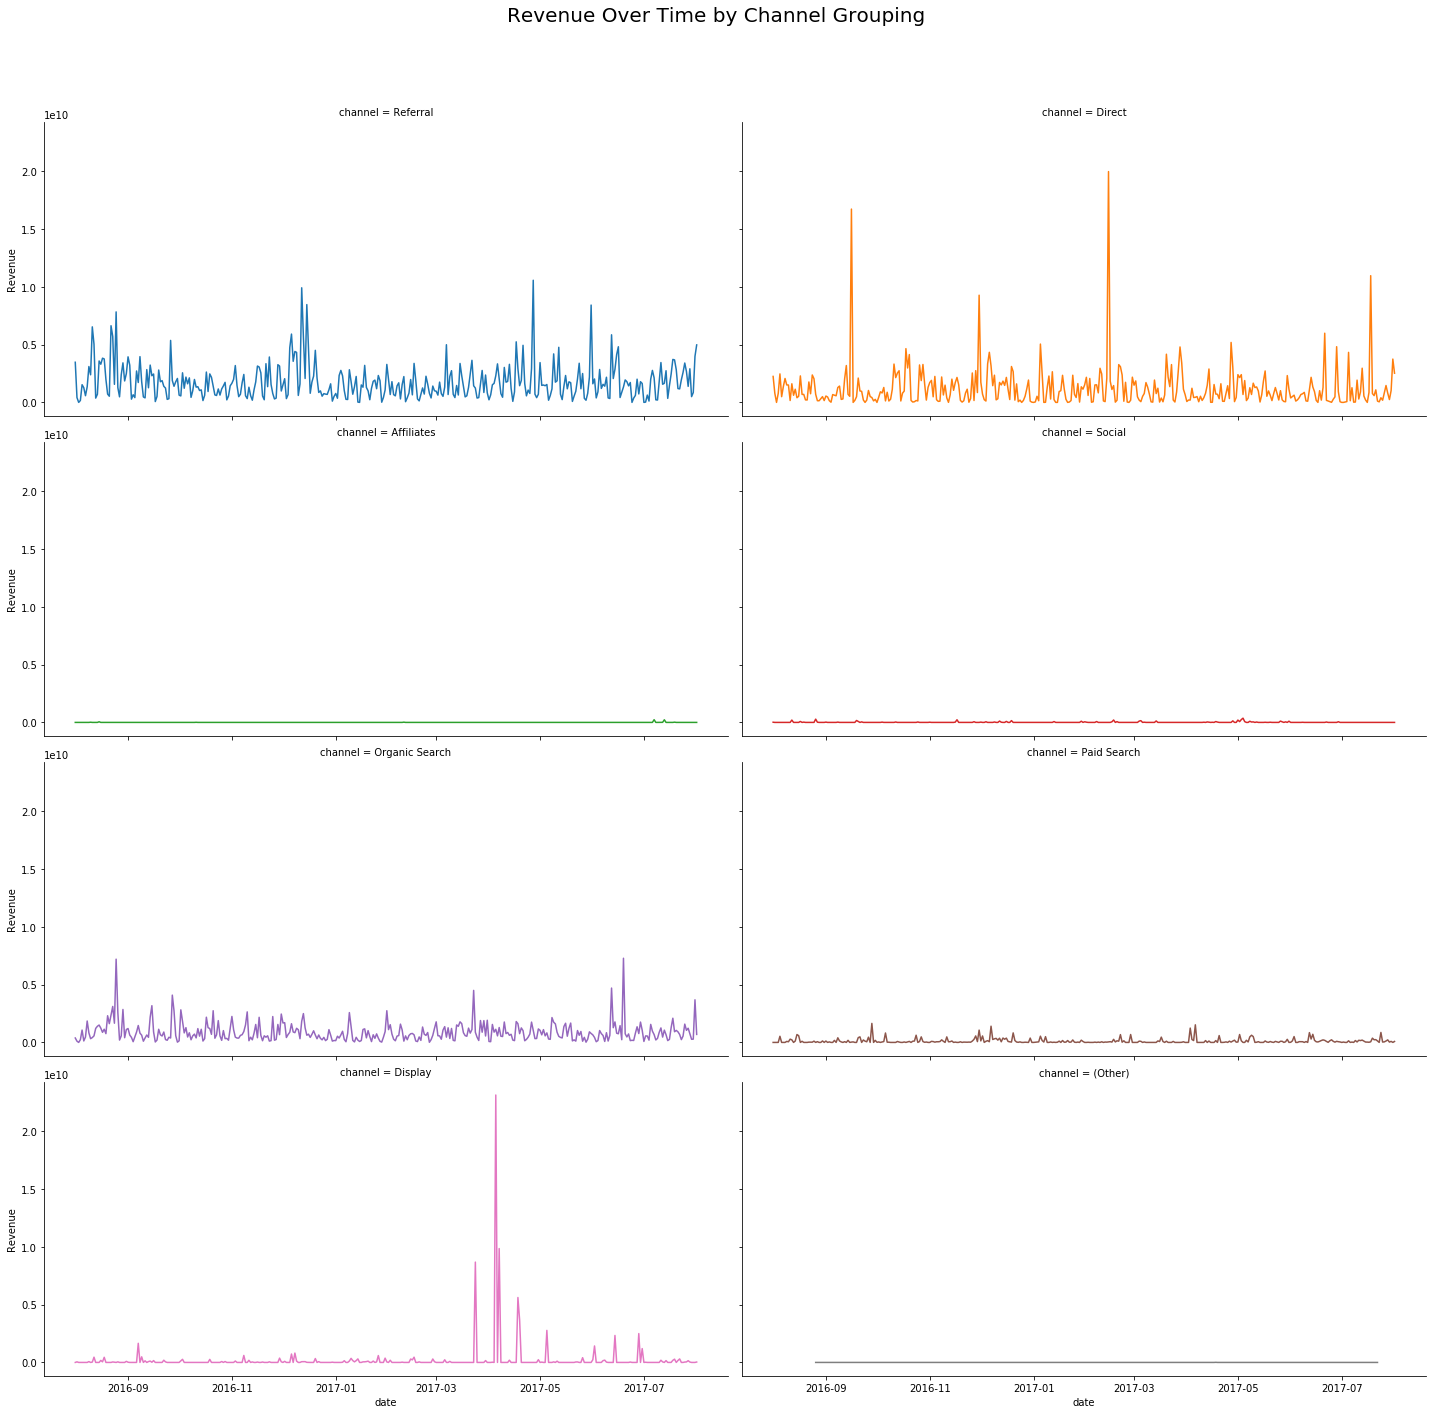

In [146]:
#plotting multiple graphs of Revenue over time by channel grouping
import seaborn as sns
import matplotlib.pyplot as plt
area = sns.FacetGrid(df_new, col = 'channel', hue = 'channel', height=5, aspect=2, col_wrap = 2) 
channel_area = area.map(sns.lineplot, 'date', 'Revenue')
plt.subplots_adjust(top=0.9)
channel_area.fig.suptitle('Revenue Over Time by Channel Grouping',  fontsize=20) 
channel_area

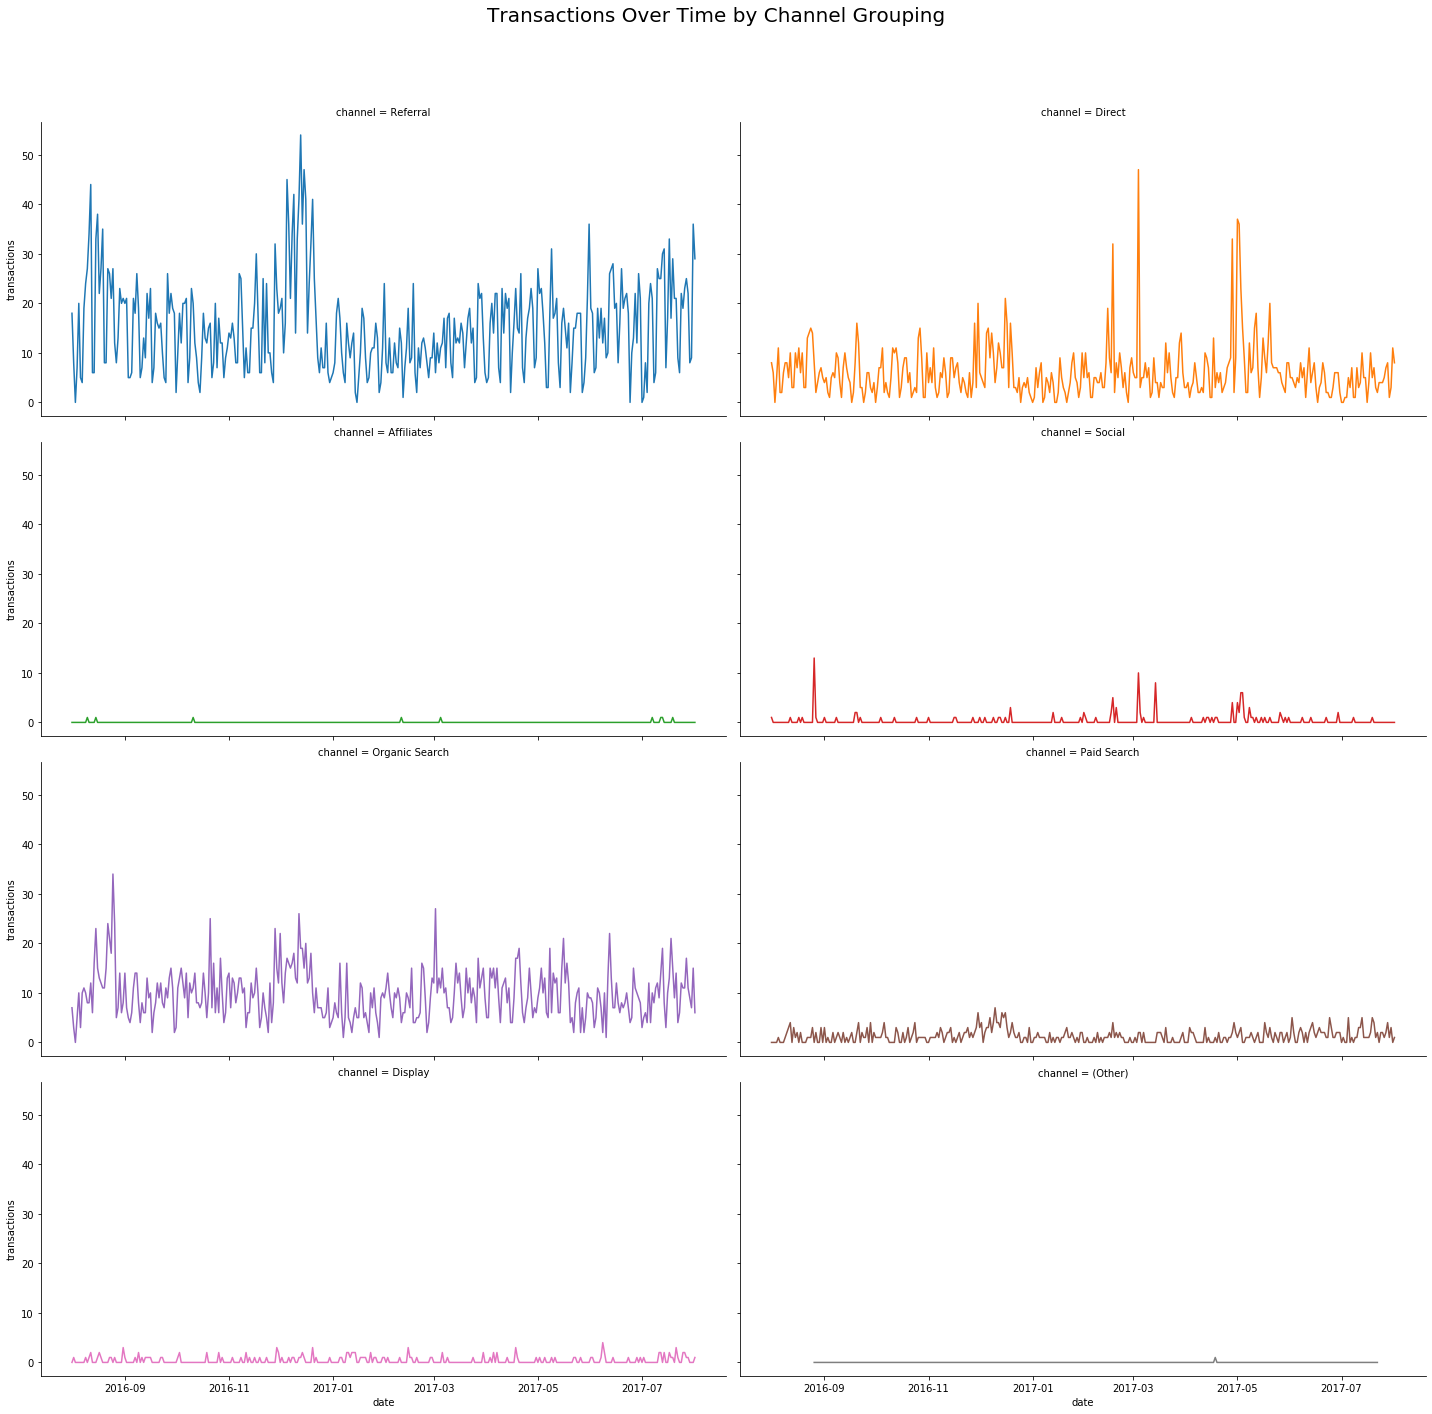

In [177]:
#plotting transactions overtime by channel grouping
area = sns.FacetGrid(df_new, col = 'channel', hue = 'channel', height=5, aspect=2, col_wrap = 2) 
channel_area = area.map(sns.lineplot, 'date', 'transactions')
plt.subplots_adjust(top=0.9)
channel_area.fig.suptitle('Transactions Over Time by Channel Grouping',  fontsize=20) 
channel_area

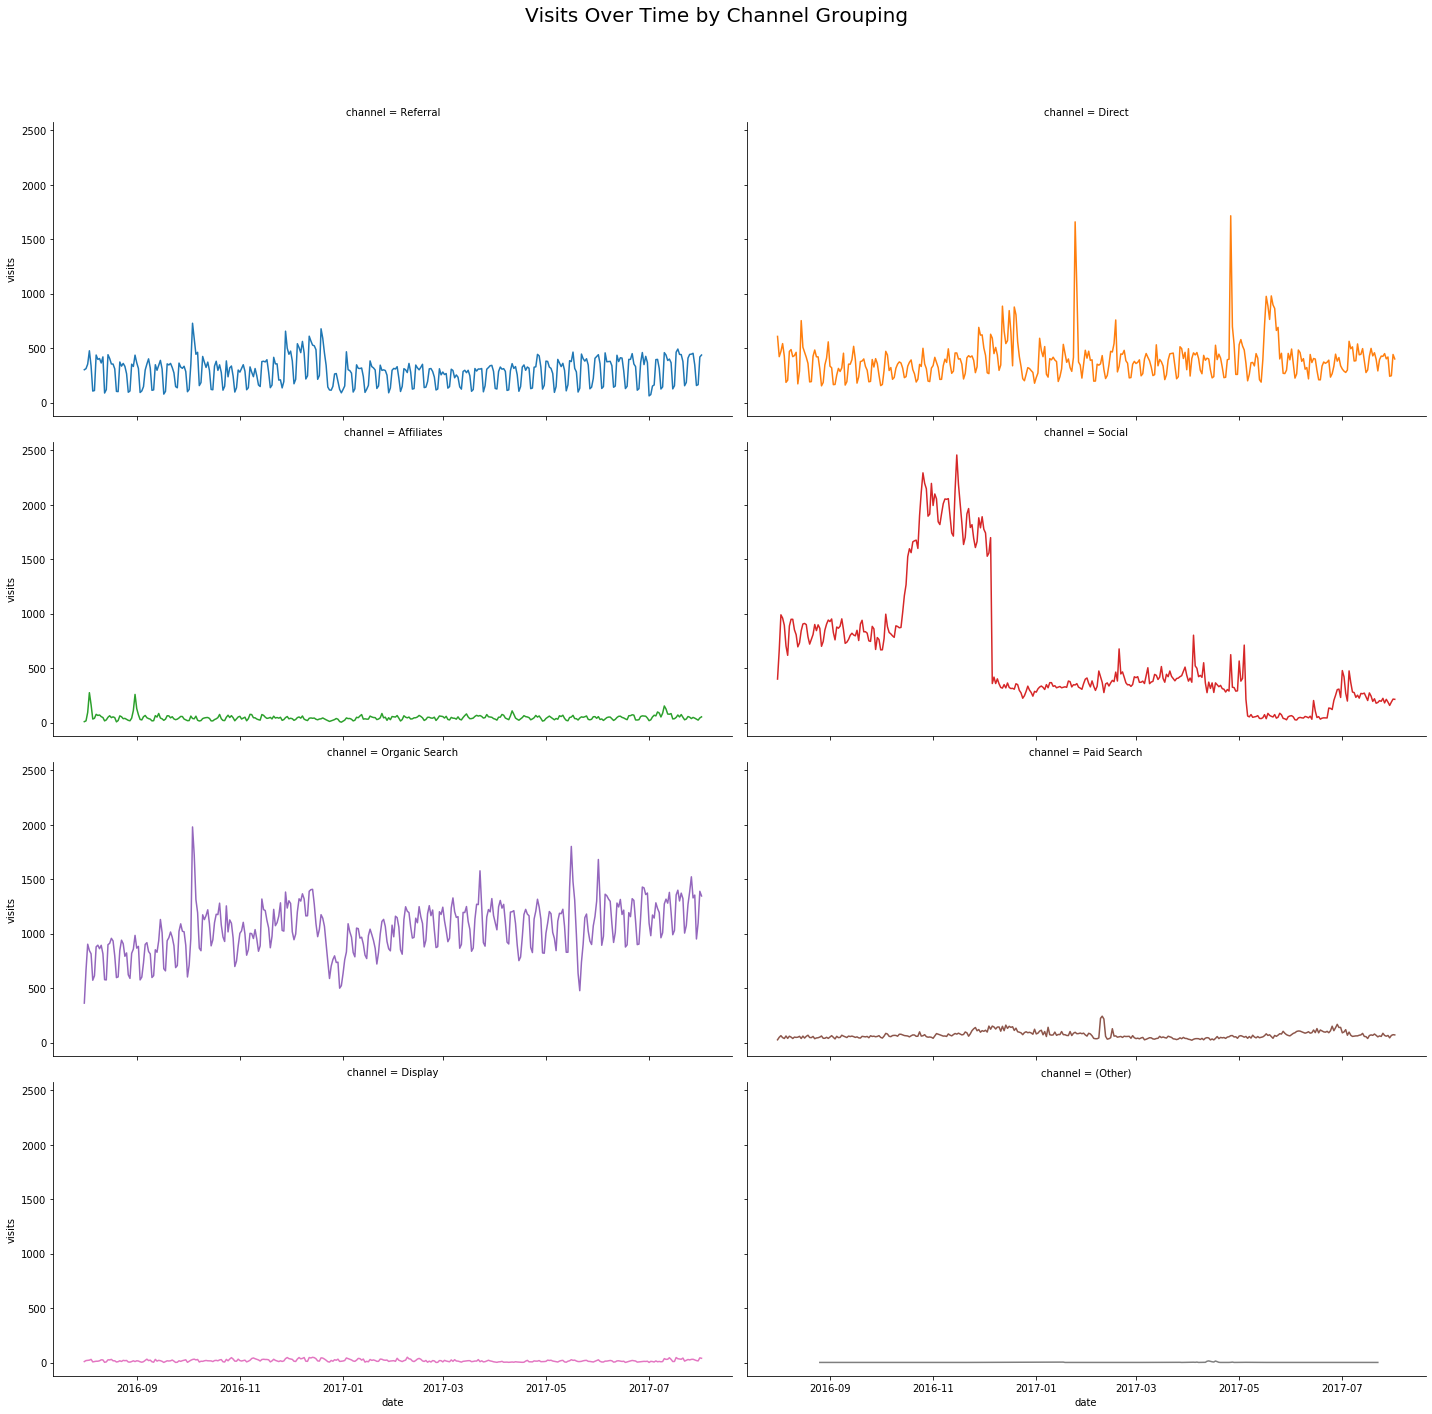

In [178]:
#graphing visits over time by channel gouping
area = sns.FacetGrid(df_new, col = 'channel', hue = 'channel', height=5, aspect=2, col_wrap = 2) 
channel_area = area.map(sns.lineplot, 'date', 'visits')
plt.subplots_adjust(top=0.9)
channel_area.fig.suptitle('Visits Over Time by Channel Grouping',  fontsize=20) 
channel_area

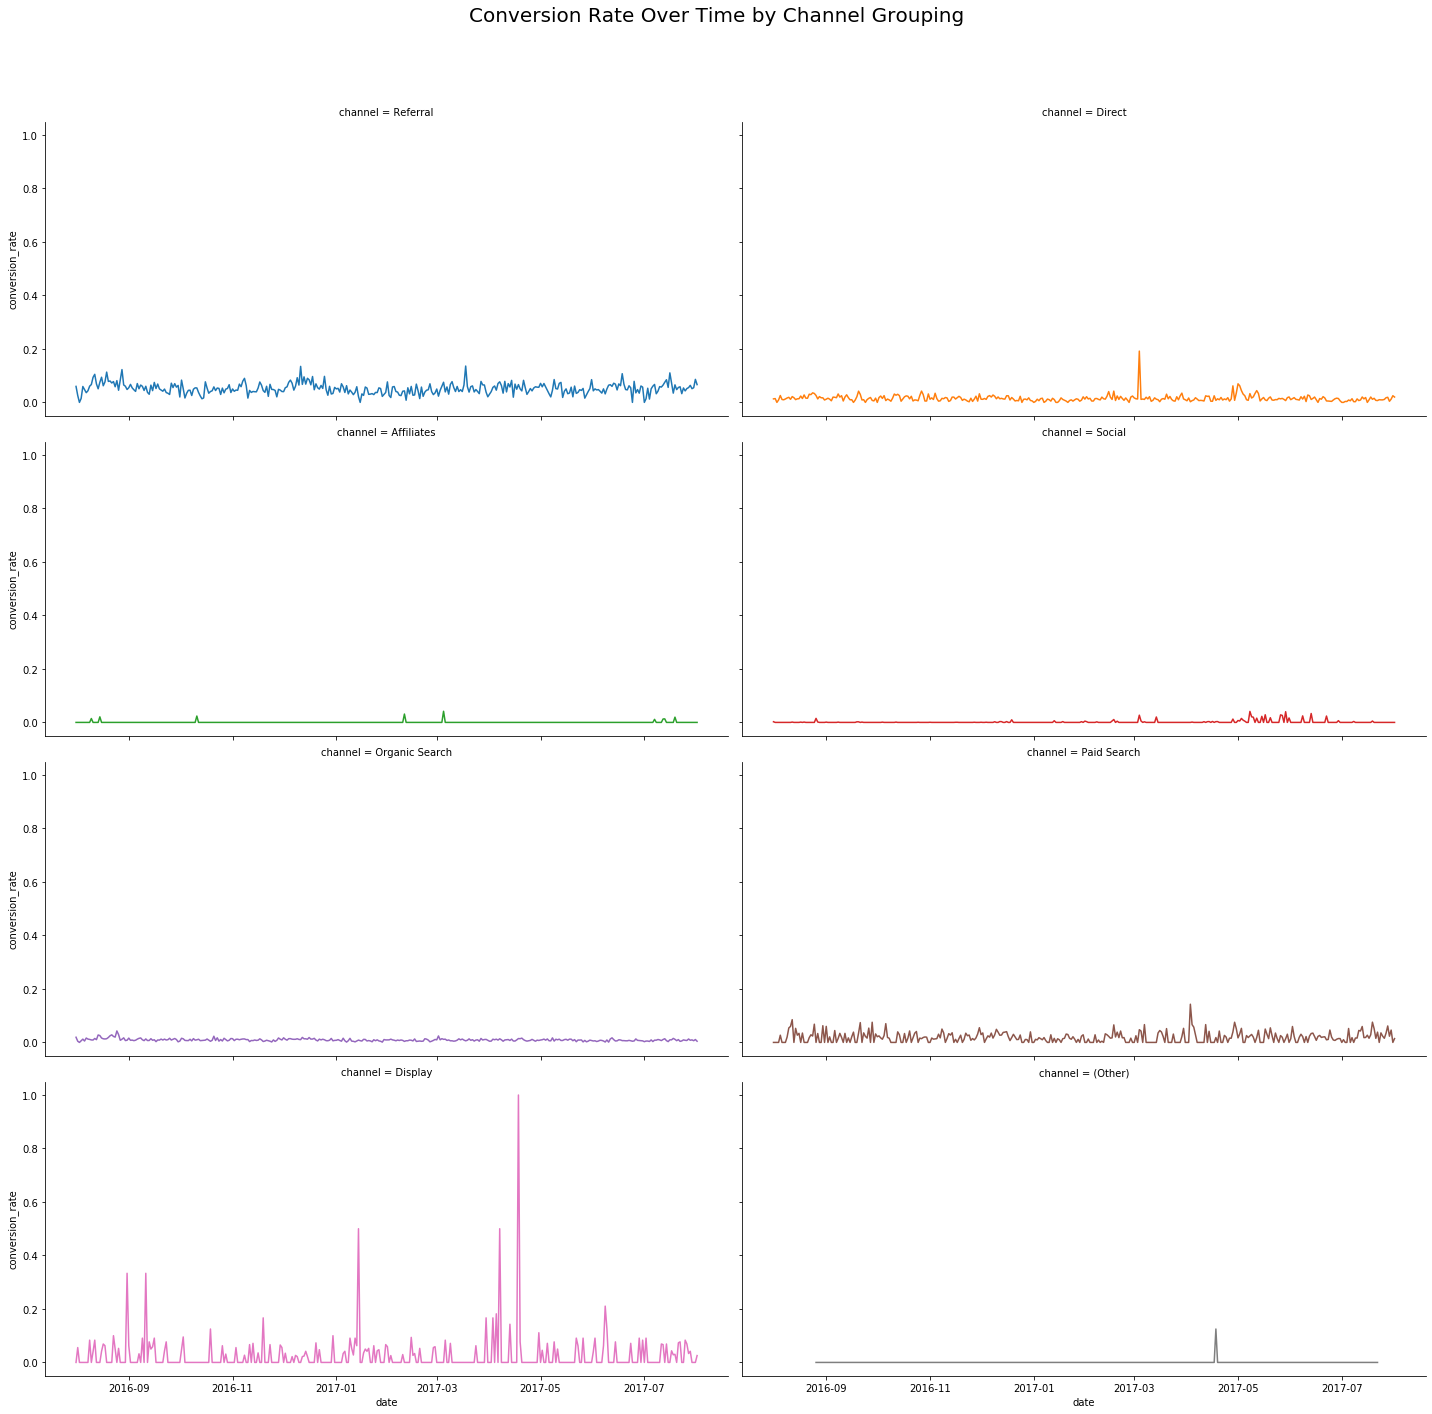

In [179]:
#graphing conversion_rate over time by channel grouping
area = sns.FacetGrid(df_new, col = 'channel', hue = 'channel', height=5, aspect=2, col_wrap = 2) 
channel_area = area.map(sns.lineplot, 'date', 'conversion_rate')
plt.subplots_adjust(top=0.9)
channel_area.fig.suptitle('Conversion Rate Over Time by Channel Grouping',  fontsize=20) 
channel_area

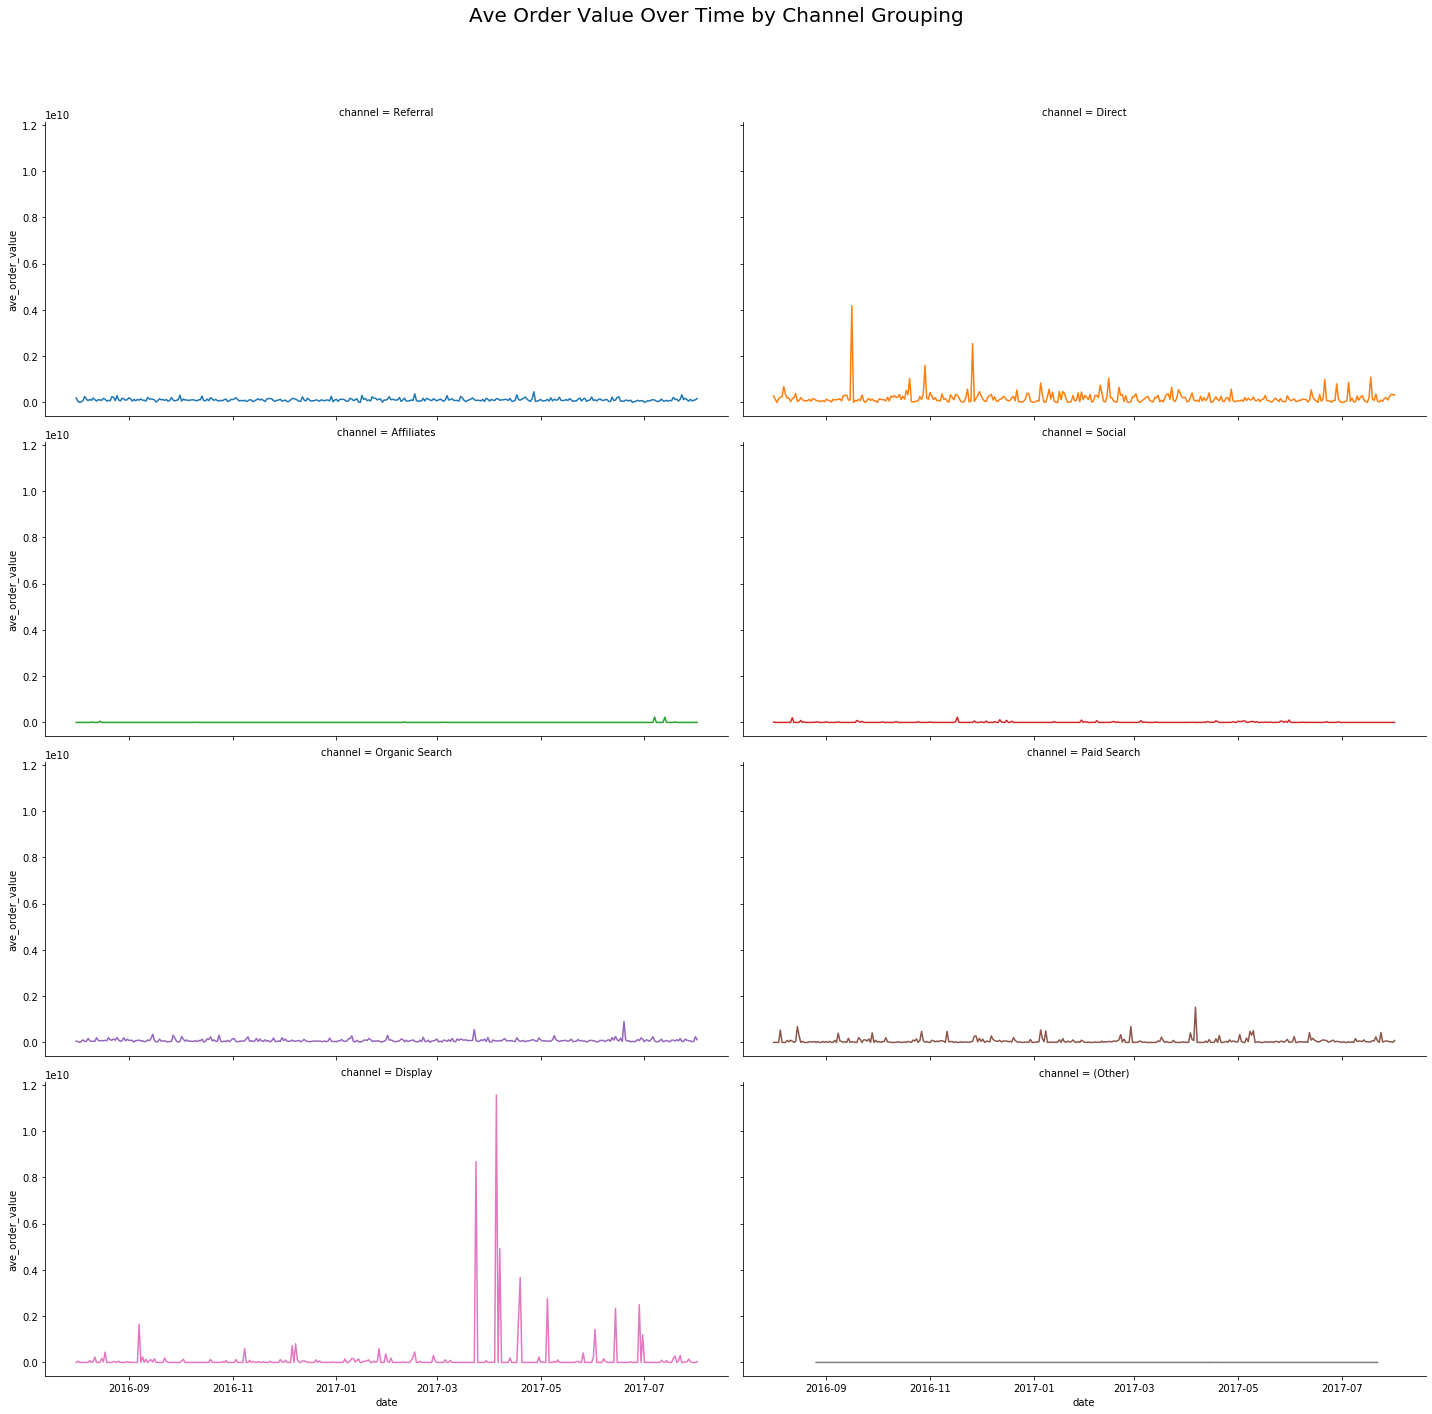

In [181]:
#graphing ave_order_value over time by channel grouping
area = sns.FacetGrid(df_new, col = 'channel', hue = 'channel', height=5, aspect=2, col_wrap = 2) 
channel_area = area.map(sns.lineplot, 'date', 'ave_order_value')
plt.subplots_adjust(top=0.9)
channel_area.fig.suptitle('Ave Order Value Over Time by Channel Grouping',  fontsize=20) 
channel_area